In [1]:
import os
import librosa
import librosa.display
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt

In [2]:
def padd_audio(audio, max_duration=15, sample_rate=16000):
    """This function take an audio and padd that audio with zeros"""
    
    max_length = max_duration * sample_rate
    padding_needed = max_length - len(audio)
    pad_left = padding_needed // 2
    pad_right = padding_needed - pad_left
    
    return np.pad(audio, (pad_left, pad_right), 'constant')

In [3]:
def mix_audio(original_audio_path, noise_audio_path, sample_rate=16000):
    """This function take an original audio and noise audio and mix it together"""
    
    # Load the original audio
    original_audio, sr = librosa.load(original_audio_path, sr=sample_rate)
    
    #Padd original audio
    original_audio = padd_audio(original_audio, sample_rate=sample_rate)
    
    # Load the noise audio
    noise_audio, sr_noise = librosa.load(noise_audio_path, sr=sample_rate)
    
    # Repeat the noise audio
    noise_audio = np.tile(noise_audio, int(np.ceil(len(original_audio) / len(noise_audio))))

    # Trim the repeated noise audio to match the length of the original audio
    noise_audio = noise_audio[:len(original_audio)]
    
    return original_audio + noise_audio/2

In [4]:
sr = 16000  # Sampling rate
frame_length_ms = 25  # Frame length in milliseconds
frame_length = int(frame_length_ms * sr / 1000)  # Frame length in samples
hop_length_frame = frame_length // 2  # Hop length (50% overlap)   

In [5]:
#Example usage
sound1 = mix_audio(os.path.join(os.getcwd(), 'Dataset', '89-218-0001.flac'), os.path.join(os.getcwd(), 'Noise', '5-202898-A-10.wav'))
print(sound1.shape)

sound2 = mix_audio(os.path.join(os.getcwd(), 'Dataset', '89-218-0003.flac'), os.path.join(os.getcwd(), 'Noise', '5-202898-A-10.wav'))
print(sound2.shape)

(240000,)
(240000,)


In [6]:
sf.write('noisy_audio.wav', sound1, sr)

In [7]:
# Randmly chosen noise for each audio
def combine_audio_with_noise(original_audio_dir, noise_audio_dir):
    combination_dict = {}
    noise_audios = os.listdir(noise_audio_dir)
    original_audios = os.listdir(original_audio_dir)
    
    for original_audio in original_audios:
        noise_audio = np.random.choice(noise_audios)
        combination_dict[os.path.join(original_audio_dir, original_audio)] = os.path.join(noise_audio_dir, noise_audio)
        
    return combination_dict

In [8]:
audio_noise_pairs = combine_audio_with_noise(os.path.join(os.getcwd(), 'Dataset'), os.path.join(os.getcwd(), 'Noise'))

#Getting all the mixed audio matrices
mixed_audios = np.zeros(len(audio_noise_pairs), dtype=object)
for index, (audio_dir, noise_dir) in enumerate(audio_noise_pairs.items()):
    mixed_audios[index] = mix_audio(audio_dir, noise_dir, sample_rate=16000)

In [9]:
def audio_to_stft(audio, n_fft=400, hop_length_fft=200):
    # STFT transformation
    stftaudio = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length_fft)

    # Extract magnitude and phase
    stftaudio_magnitude, stftaudio_phase = librosa.magphase(stftaudio)

    # Convert magnitude to dB
    stftaudio_magnitude_db = librosa.amplitude_to_db(stftaudio_magnitude, ref=np.max)
    
    return stftaudio_magnitude_db, stftaudio_phase

In [10]:
def stft_to_audio(stftaudio_magnitude_db, stftaudio_phase, hop_length_fft=200):
# Convert dB back to amplitude
    stftaudio_magnitude_rev = librosa.db_to_amplitude(stftaudio_magnitude_db, ref=1.0)

    # Reconstruct the STFT complex matrix
    audio_reverse_stft = stftaudio_magnitude_rev * stftaudio_phase

    # Inverse STFT to get back the audio signal
    audio_reconstruct = librosa.istft(audio_reverse_stft, hop_length=hop_length_fft)

    return audio_reconstruct / np.max(np.abs(audio_reconstruct))

In [11]:
sound1 = mix_audio(os.path.join(os.getcwd(), 'Dataset', '89-218-0001.flac'), os.path.join(os.getcwd(), 'Noise', '5-202898-A-10.wav'))

In [12]:
stftaudio_magnitude_db, stftaudio_phase = audio_to_stft(sound1)

In [13]:
reconstructed_audio = stft_to_audio(stftaudio_magnitude_db, stftaudio_phase)

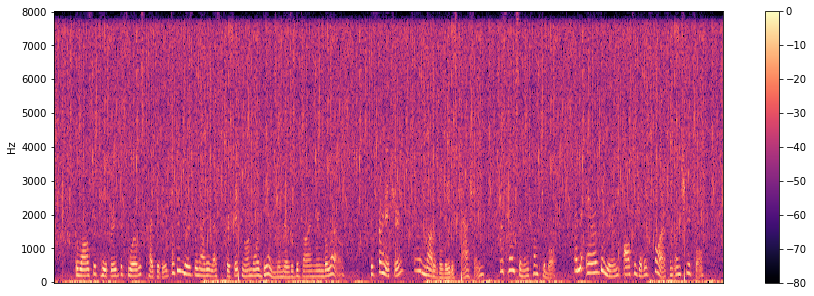

In [16]:
# Plot the spectrogram
plt.figure(figsize=(15, 5))  # Initialize the fig size
librosa.display.specshow(stftaudio_magnitude_db, sr=sr, y_axis='hz')
plt.colorbar()
plt.show()

In [15]:
sf.write('reconstructed_audio.wav', reconstructed_audio, sr)
sf.write('noisy_audio.wav', sound1, sr)